5. .
        
        a. Obtener una simulación de un modelado de Erdös-Rényi que corresponda a los parámetros de esta red.
        b. Obtener una simulación de un modelado de Preferential Attachment (ley de potencias) que corresponda a los parámetros de esta red.
        c. Obtener una representación de anonymous walks tanto de la red original como para las dos simuladas en los puntos a y b. Determinar por distancia coseno cuál sería la simulación más afín.
    
    **[3 puntos]**

In [29]:
import networkx as nx
import pandas as pd
import sys
sys.path.append('../')
from social_networks_utils.homofilia import contar_aristas
from social_networks_utils.modelos import erdos_renyi
from social_networks_utils.metricas import grado_promedio, clustering

In [30]:
net = pd.read_csv('../data/World.csv')
net.head()

,Origen,Destino
0,Papua New Guinea,Australia
1,Papua New Guinea,Philippines
2,Papua New Guinea,Indonesia
3,Papua New Guinea,Solomon Islands
4,Papua New Guinea,Hong Kong


In [31]:
G = nx.from_pandas_edgelist(net,'Origen','Destino')

In [32]:
def graph_info_to_dict(G):
    d = {}
    d['Diametro'] = 5
    d['Grado Promedio'] = grado_promedio(G)
    d['Coeficiente de clustering'] = clustering(G)[1]
    d['Cantidad de aristas'] = contar_aristas(G)
    return d

In [33]:
G_dict = graph_info_to_dict(G)

### Modelado de Erdös-Rényi

In [34]:
grado_promedio_ = grado_promedio(G)
cant_aristas = G.number_of_edges()
cant_nodos = G.number_of_nodes()

In [35]:
er_graph = erdos_renyi(cant_nodos,grado_promedio_)

In [36]:
def graph_to_csv(G,path):
    d = {'origen': [], 'destino': []}
    for edge in list(G.edges()):
        d['origen'].append(edge[0])
        d['destino'].append(edge[1])
    pref_attach_df = pd.DataFrame(data=d)
    pref_attach_df.to_csv(path,index=False)
    

In [37]:
graph_to_csv(er_graph,'../data/er_graph.csv')

In [38]:
er_dict = graph_info_to_dict(er_graph)

In [39]:
df = pd.DataFrame([G_dict, er_dict]).T
columns = ['Red real','Erdös-Rényi']
df.columns = columns

In [40]:
df

,Red real,Erdös-Rényi
Diametro,5.000000,5.000000
Grado Promedio,24.908297,24.820961
Coeficiente de clustering,0.660157,0.111859
Cantidad de aristas,2852.000000,2842.000000


### Modelado de Preferential Attachment (ley de potencias)

In [41]:
from social_networks_utils.metricas import alfa_preferential_attachment, distrubucion_ccdf, graficar_distribuciones
from social_networks_utils.embeddings import ln
from social_networks_utils.modelos import preferential_attachment

In [42]:
def calculate_alpha(G: nx.Graph,x_m: int):
    result = 0
    for n in list(G.nodes()):
        result += ln((G.degree(n)/x_m))
    result = result ** (-1)
    result = result * (1 + G.number_of_nodes())
    return result + 1


Lo ideal seria encontrar un alpha entre 2 y 3, ya que:

* $α <= 2, E[X] = ∞$ 
* $α <= 3, V[X] = ∞$

Con x<sub>m</sub> = 6 el alpha da menor a 2.

In [43]:
alfa_preferential_attachment(G,6)

1.9314931023124609

Con x<sub>m</sub> = 14 el alpha da mayor a 3.

In [44]:
alfa_preferential_attachment(G,14)

3.07739187606002

Voy a buscar un alpha entre x<sub>m</sub> = 7 y x<sub>m</sub> = 13 que quede mejor con las distribuciones CCDF... a ojimetro

In [45]:
distribucion_ccdf_G = distrubucion_ccdf(G)

Xm = 7
Alfa:  2.053726293697296


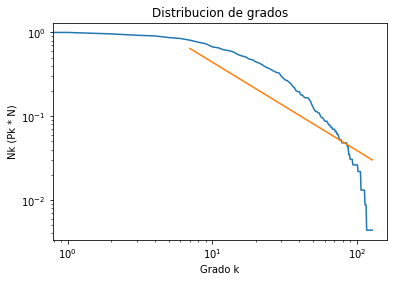

Xm = 8
Alfa:  2.180680191366131


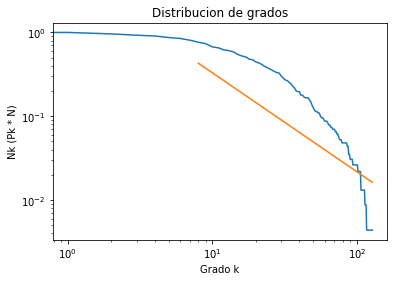

Xm = 9
Alfa:  2.314819119085215


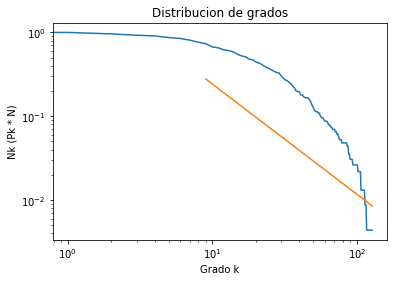

Xm = 10
Alfa:  2.449890843293105


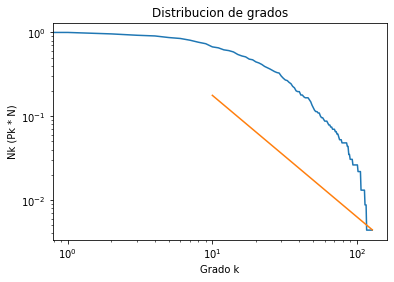

Xm = 11
Alfa:  2.594192433181231


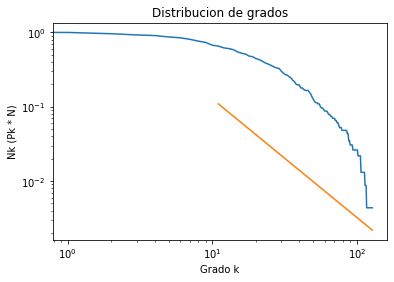

Xm = 12
Alfa:  2.7442199407427355


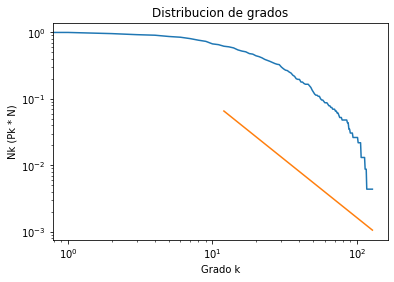

Xm = 13
Alfa:  2.9057154261138387


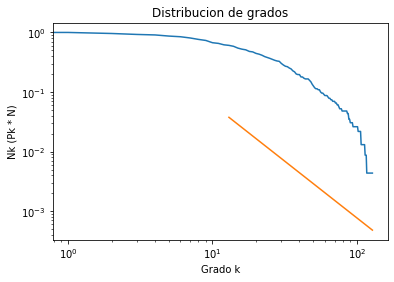

In [46]:
for x_m in range(7,14):
    print("Xm =",x_m)
    alpha = alfa_preferential_attachment(G,x_m)
    graficar_distribuciones(distribucion_ccdf_G,alpha,x_m)

El x<sub>m</sub> que me parece que mejor queda para la distribucion de grados es entre **x<sub>m</sub> = 7**

In [47]:
alpha = alfa_preferential_attachment(G,6)
pref_attach_graph = preferential_attachment(False,alpha,cant_nodos,grado_promedio_)

In [48]:
graph_to_csv(pref_attach_graph,'../data/pref_attach_graph.csv')

In [49]:
pref_attach_dict = graph_info_to_dict(pref_attach_graph)

In [50]:
df.insert(2,"Preferential Attachment",list(pref_attach_dict.values()),False)

In [51]:
df

,Red real,Erdös-Rényi,Preferential Attachment
Diametro,5.000000,5.000000,5.000000
Grado Promedio,24.908297,24.820961,43.144105
Coeficiente de clustering,0.660157,0.111859,0.186079
Cantidad de aristas,2852.000000,2842.000000,4940.000000


### Comparacion entre grafos

<table>
  <tr>
    <td>Red Original</td>
     <td>Erdös-Rényi</td>
     <td>Preferential Attachment</td>
  </tr>
  <tr>
    <td><img src="../media/original_net.png" width=500></td>
    <td><img src="../media/erdos-renyi.png" width=500></td>
    <td><img src="../media/preferential_attachment.png" width=500></td>
  </tr>
 </table>

### Representación de anonymous walks

In [52]:
from social_networks_utils.embeddings import anoymous_walks
from social_networks_utils.metricas import distancia_coseno

In [53]:
caminos_G, emb_G = anoymous_walks(G,7)
caminos_er, emb_er = anoymous_walks(er_graph,7)
caminos_pa, emb_pa = anoymous_walks(pref_attach_graph,7)

In [54]:
distancia_coseno(emb_G,emb_er)

0.00044853931648569656

In [55]:
distancia_coseno(emb_G,emb_pa)    

0.0015958170822956141

In [56]:
df

,Red real,Erdös-Rényi,Preferential Attachment
Diametro,5.000000,5.000000,5.000000
Grado Promedio,24.908297,24.820961,43.144105
Coeficiente de clustering,0.660157,0.111859,0.186079
Cantidad de aristas,2852.000000,2842.000000,4940.000000


El modelo mas a fin para la red original segun la distancia coseno es la de Erdös-Rényi. Tiene sentido al comparar algunos datos de los grafos.